# Example of how to load a trained checkpoint

In [71]:
import os
import sys
sys.path.append("..")

import wandb
import hydra
import omegaconf
import jax
import optax
from flax.training.train_state import TrainState
from flax.serialization import from_bytes

from src.models.lpn import LPN
from src.evaluator import Evaluator
from src.models.transformer import EncoderTransformer, DecoderTransformer
from src.train import Trainer

In [76]:
artifact_path = "TheThinker/ARC/absurd-river-1068--checkpoint:v2"

## Download WandB artifact (model weights + configs)

In [ ]:
run = wandb.init()
artifact = run.use_artifact(artifact_path, type='model')
run.finish()
cfg = omegaconf.OmegaConf.create(artifact.metadata)
artifact_dir = artifact.download()
omegaconf.OmegaConf.save(config=cfg, f=os.path.join(artifact_dir, "config.yaml"))

## Instantiate model from configs

In [ ]:
encoder = EncoderTransformer(hydra.utils.instantiate(cfg.encoder_transformer))
decoder = DecoderTransformer(hydra.utils.instantiate(cfg.decoder_transformer))
lpn = LPN(encoder=encoder, decoder=decoder)

key = jax.random.PRNGKey(0)
grids = jax.random.randint(
    key, (1, 3, decoder.config.max_rows, decoder.config.max_cols, 2), minval=0, maxval=decoder.config.vocab_size,
)
shapes = jax.random.randint(
    key, (1, 3, 2, 2), minval=1, maxval=min(decoder.config.max_rows, decoder.config.max_cols) + 1,
)
variables = lpn.init(key, grids, shapes, dropout_eval=False, prior_kl_coeff=0.0, pairwise_kl_coeff=0.0, mode="mean")
evaluator = Evaluator(lpn, inference_mode="mean", inference_mode_kwargs={}, devices=None)

learning_rate, linear_warmup_steps = 0, 0
linear_warmup_scheduler = optax.warmup_exponential_decay_schedule(
    init_value=learning_rate / (linear_warmup_steps + 1),
    peak_value=learning_rate,
    warmup_steps=linear_warmup_steps,
    transition_steps=1,
    end_value=learning_rate,
    decay_rate=1.0,
)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(linear_warmup_scheduler))
optimizer = optax.MultiSteps(optimizer, every_k_schedule=1)
train_state = TrainState.create(apply_fn=lpn.apply, tx=optimizer, params=variables["params"])

## Load checkpoint

In [5]:
ckpt_path = "state.msgpack"

with open(os.path.join(artifact_dir, ckpt_path), "rb") as data_file:
    byte_data = data_file.read()
loaded_state = from_bytes(train_state, byte_data)
pmapped_state = jax.device_put_replicated(loaded_state, evaluator.devices)

## Inference on a json file

In [ ]:
import json

from src.visualization import visualize_json_submission

with open("datasets/json/arc-agi_training_challenges.json", "r") as f:
    challenges = json.load(f)
with open("datasets/json/arc-agi_training_solutions.json", "r") as f:
    solutions = json.load(f)
generations = {task_id: [{"attempt_1": sol, "attempt_2": sol} for sol in sols] for task_id, sols in solutions.items()}
fig_grids = visualize_json_submission(challenges, generations, solutions, num_tasks=400)

In [ ]:
import matplotlib.pyplot as plt

num_tasks = 400
keys = list(generations.keys())[:num_tasks]
num_tasks = len(keys)
# Find the maximum number of (train + test) pairs throughout all tasks
max_num_pairs = max(
    len(challenge["train"]) + len(challenge["test"])
    for task_id, challenge in challenges.items()
    if task_id in generations
)
height_ratios = num_tasks * [1, 1, 1, 0.2]  # Input, True Output, Predicted Output, Line
fig, axs = plt.subplots(
    4 * num_tasks - 1,
    max_num_pairs,
    figsize=(3 * max_num_pairs, 9.6 * num_tasks - 0.6),
    height_ratios=height_ratios[:-1],
    dpi=min(100, int(100/(num_tasks/60))),  # Limit the total number of pixels
)

In [ ]:
metrics, fig = Trainer.test_json_submission(
    pmapped_state,
    evaluator,
    json_challenges_file="datasets/json/arc-agi_training_challenges.json",
    json_solutions_file="datasets/json/arc-agi_training_solutions.json",
    test_name="ARC-AGI train",
    key=jax.random.PRNGKey(0),
    only_n_tasks=400,  # 'None' to run on all tasks
    progress_bar=True,
)
metrics

# Analyze Latent Space

## Preparation

In [6]:
import matplotlib.pyplot as plt

from src.visualization import display_function_examples, display_grid
from src.data_utils import load_datasets

In [7]:
from huggingface_hub import interpreter_login
interpreter_login(new_session=False)

User is already logged in.


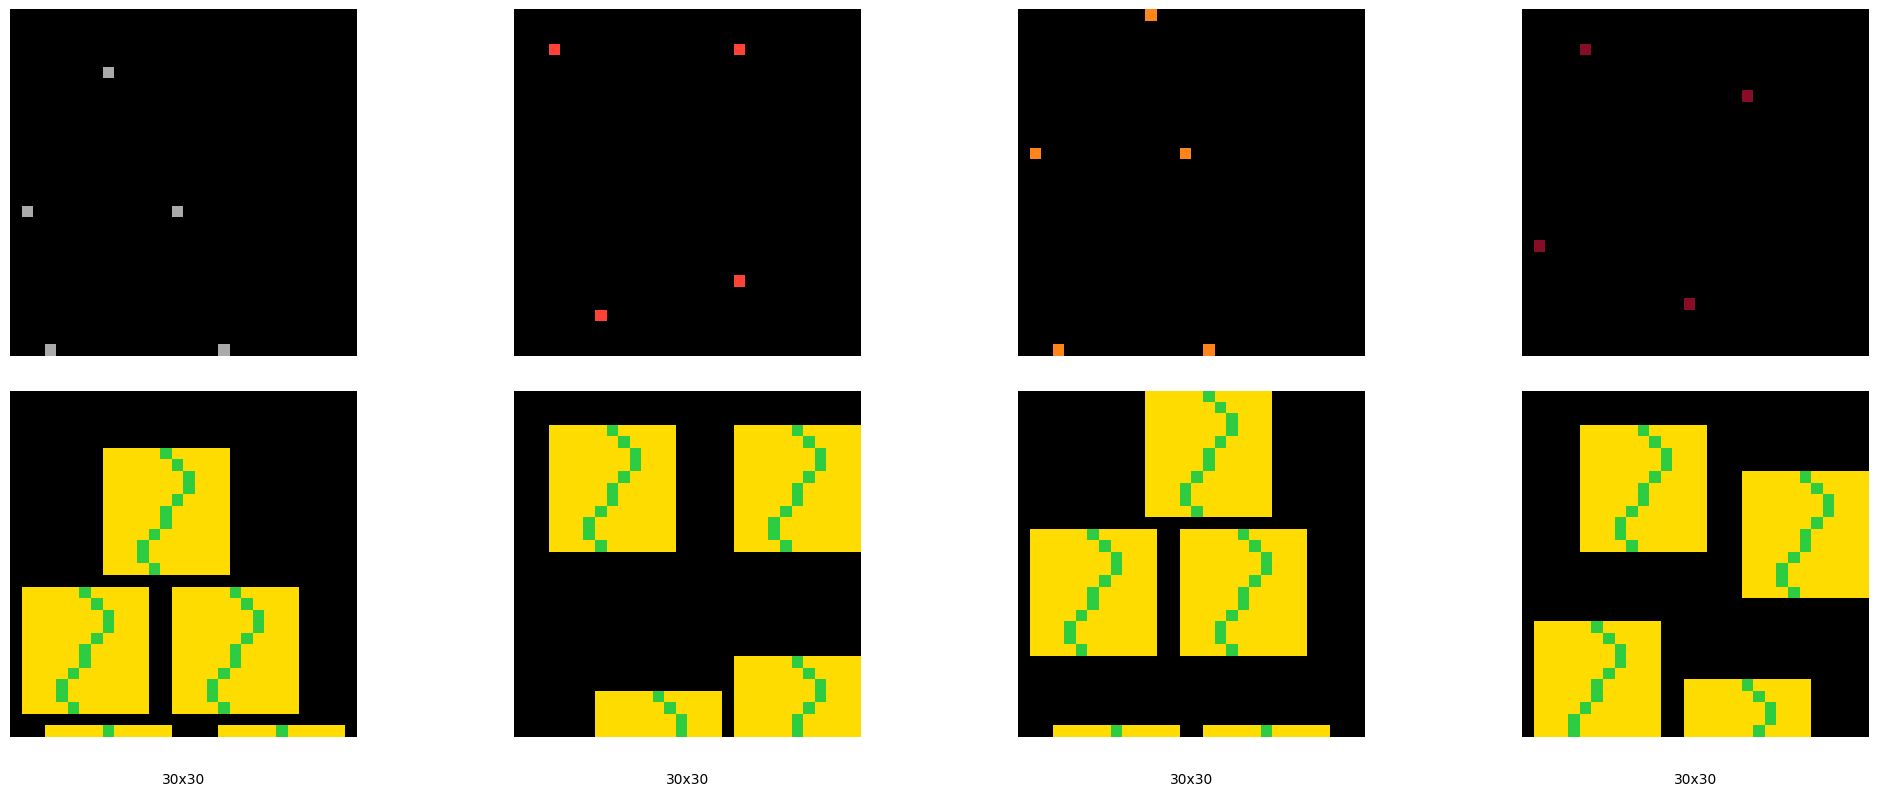

In [8]:
# Load the dataset and grid shapes
grids, shapes, ids = load_datasets(["storage/v0_main_fix_test"], use_hf=True)[0]

# Display examples for a random function
grid, shape = display_function_examples(grids, shapes, seed=13)

In [39]:
pairs = grid[None, 1:, :, :, :]
grid_shapes = shape[None, 1:, :, :]
input = grid[None, 0, :, :, 0]
input_grid_shape = shape[None, 0, :, 0]
output = grid[None, 0, :, :, 1]
output_grid_shape = shape[None, 0, :, 1]
key = jax.random.PRNGKey(0)
dropout_eval = True
mode = "mean"
return_two_best = False

latents = lpn.encoder.apply({"params": loaded_state.params["encoder"]}, pairs, grid_shapes, dropout_eval)
latents.shape

(1, 3, 32)

In [10]:
jax.numpy.linalg.norm(latents, axis=-1)

Array([[26.71949 , 26.861319, 27.35863 ]], dtype=float32)

## Random Search

In [50]:
scale = jax.numpy.array([0.0, 1.0, 10.0])
num_samples = scale.shape[0]
context = latents.mean(axis=-2) + scale[:, None] * jax.random.normal(jax.random.PRNGKey(0), (num_samples, 32))
context.shape

(3, 32)

In [ ]:
output_grids, output_shapes = lpn.apply(
    {"params": loaded_state.params}, context, input.repeat(num_samples, axis=0), input_grid_shape.repeat(num_samples, axis=0), dropout_eval, method=lpn._generate_output_from_context
)
output_grids.shape

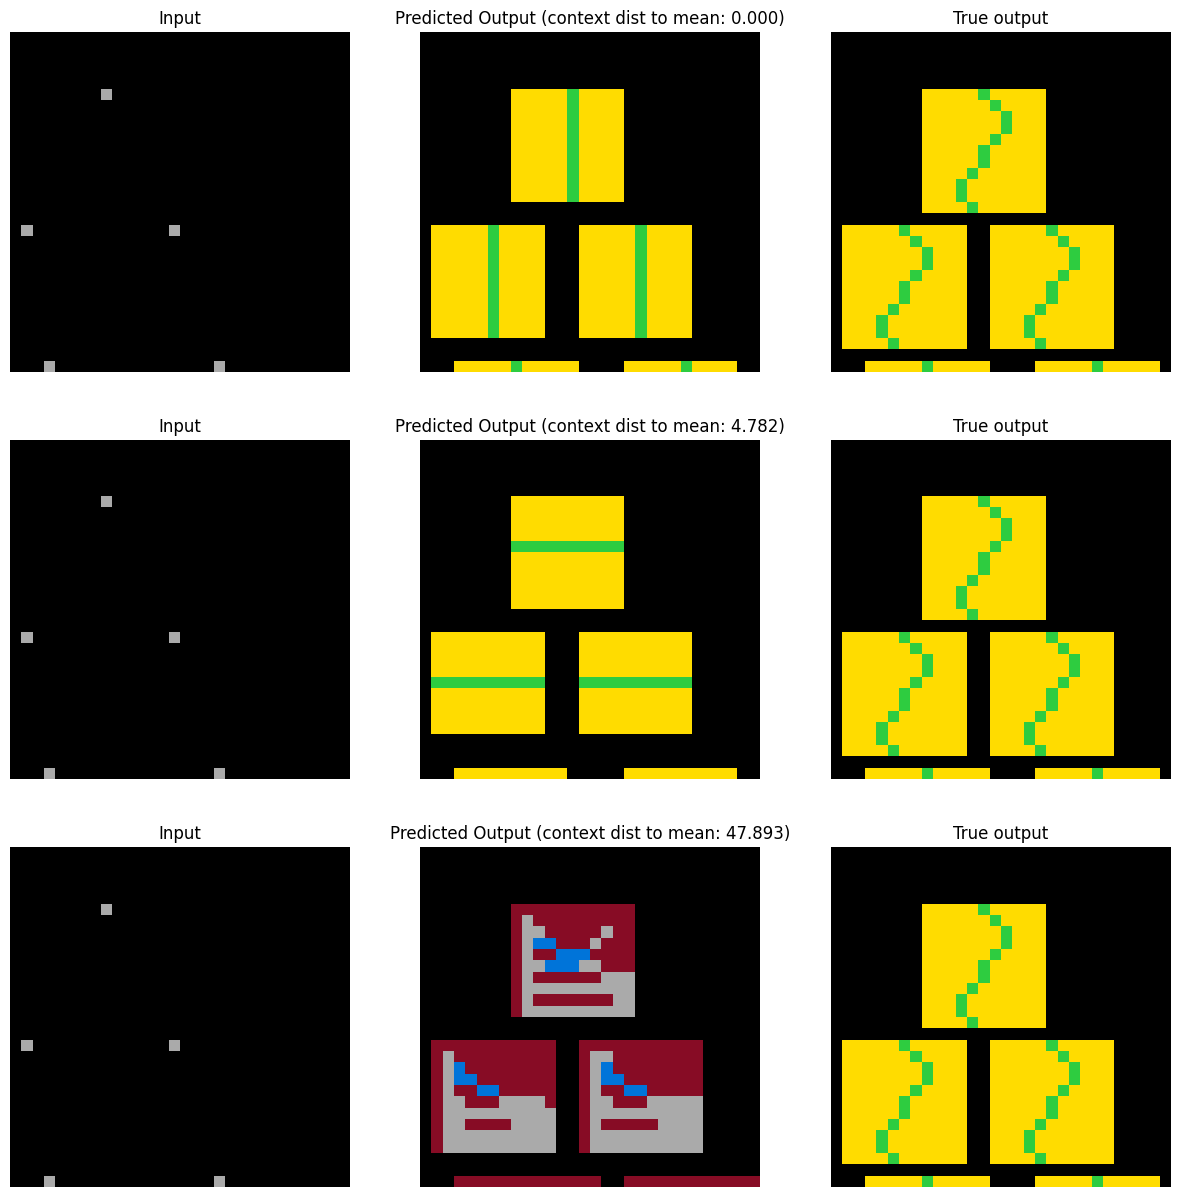

In [53]:
_, axs = plt.subplots(num_samples, 3, figsize=(15, 15))

distances = jax.numpy.linalg.norm(context - latents.mean(axis=-2, keepdims=True), axis=-1)
for i in range(num_samples):
    axs[i, 0].set_title("Input")
    display_grid(axs[i, 0], input[0], input_grid_shape[0])
    axs[i, 1].set_title("Predicted Output (context dist to mean: {:.3f})".format(distances[0, i]))
    display_grid(axs[i, 1], output_grids[i], output_shapes[i])
    axs[i, 2].set_title("True output")
    display_grid(axs[i, 2], output[0], output_grid_shape[0])
plt.show()

In [15]:
num_samples_per_scale = 10
key = jax.random.PRNGKey(0)
input_seq, output_seq = lpn._flatten_input_output_for_decoding(pairs, grid_shapes)
input_seq = input_seq.repeat(num_samples_per_scale, axis=0)
output_seq = output_seq.repeat(num_samples_per_scale, axis=0)
for scale in jax.numpy.linspace(0.0, 1.0, 21):
    key, subkey = jax.random.split(key)
    contexts = latents.mean(axis=-2) + scale[None, None] * jax.random.normal(subkey, (num_samples_per_scale, 32))
    row_logits, col_logits, grid_logits = lpn.decoder.apply({"params": loaded_state.params["decoder"]}, input_seq, output_seq, contexts[:, None].repeat(3, axis=1), dropout_eval=True)
    log_probs = lpn.apply({"params": loaded_state.params}, row_logits, col_logits, grid_logits, output_seq, method=lpn._compute_log_probs)
    print(f"{scale=:.2f}", f"log_probs: best ({log_probs.max():.1f}) mean ({log_probs.mean():.1f}) worst ({log_probs.min():.1f}),", f"series: {jax.numpy.sort(log_probs, descending=True)[:5]} ...")

scale=0.00 log_probs: best (-49.3) mean (-49.3) worst (-49.3), series: [-49.275795 -49.275795 -49.275795 -49.275795 -49.275795] ...
scale=0.05 log_probs: best (-47.2) mean (-49.4) worst (-51.5), series: [-47.243473 -48.09973  -48.364204 -48.84449  -49.596535] ...
scale=0.10 log_probs: best (-46.6) mean (-49.5) worst (-52.8), series: [-46.63416  -47.08104  -47.09328  -47.906593 -49.404743] ...
scale=0.15 log_probs: best (-44.1) mean (-49.8) worst (-53.5), series: [-44.066055 -46.98703  -47.77563  -49.079636 -49.277702] ...
scale=0.20 log_probs: best (-40.7) mean (-48.2) worst (-53.6), series: [-40.671665 -42.752274 -44.405    -45.361458 -48.493904] ...
scale=0.25 log_probs: best (-40.7) mean (-55.4) worst (-79.8), series: [-40.74914  -45.422966 -46.473484 -50.675472 -56.279953] ...
scale=0.30 log_probs: best (-35.3) mean (-48.6) worst (-59.8), series: [-35.30871  -40.309814 -42.525494 -46.91372  -48.16526 ] ...
scale=0.35 log_probs: best (-36.5) mean (-49.2) worst (-59.4), series: [-36.

In [22]:
num_samples_per_scale = 1000
scale = jax.numpy.array(1.0)

input_seq, output_seq = lpn._flatten_input_output_for_decoding(pairs, grid_shapes)
input_seq = input_seq.repeat(num_samples_per_scale, axis=0)
output_seq = output_seq.repeat(num_samples_per_scale, axis=0)

contexts = latents.mean(axis=-2) + scale[None, None] * jax.random.normal(jax.random.PRNGKey(0), (num_samples_per_scale, 32))
row_logits, col_logits, grid_logits = jax.lax.map(
    lambda args: lpn.decoder.apply({"params": loaded_state.params["decoder"]}, *[arg[None] for arg in args], dropout_eval=True),
    (input_seq, output_seq, contexts[:, None].repeat(3, axis=1)),
)
row_logits, col_logits, grid_logits = jax.tree_util.tree_map(lambda x: x.squeeze(axis=1), (row_logits, col_logits, grid_logits))
log_probs = jax.lax.map(
    lambda args: lpn.apply({"params": loaded_state.params}, *args, method=lpn._compute_log_probs),
    (row_logits, col_logits, grid_logits, output_seq),
)
print(f"{scale=:.2f}", f"log_probs: best ({log_probs.max():.1f}) mean ({log_probs.mean():.1f}) worst ({log_probs.min():.1f}),", f"series: {jax.numpy.sort(log_probs, descending=True)[:5]} ...")

scale=1.00 log_probs: best (-24.5) mean (-71.8) worst (-270.0), series: [-24.455816 -25.045776 -25.143793 -26.899368 -27.093401] ...


/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:9

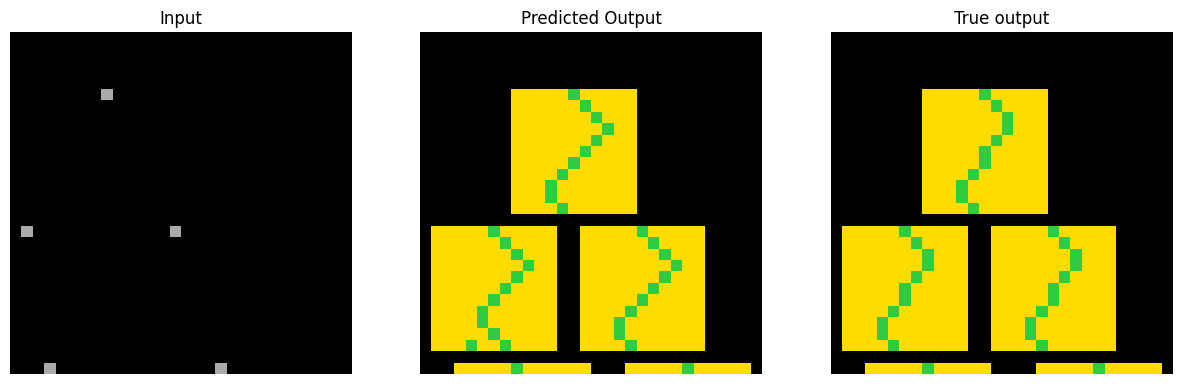

In [23]:
context = contexts[log_probs.argmax(), None]
output_grids, output_shapes = lpn.apply(
    {"params": loaded_state.params}, context, input, input_grid_shape, dropout_eval, method=lpn._generate_output_from_context
)

_, axs = plt.subplots(1, 3, figsize=(15, 10))

axs[0].set_title("Input")
display_grid(axs[0], input[0], input_grid_shape[0])
axs[1].set_title("Predicted Output")
display_grid(axs[1], output_grids[0], output_shapes[0])
axs[2].set_title("True output")
display_grid(axs[2], output[0], output_grid_shape[0])
plt.show()

In [11]:
num_samples_per_scales = [10, 30, 100, 300, 1000, 3000, 10000]
scale = jax.numpy.array(1.0)

log_probs_list = []
for num_samples_per_scale in num_samples_per_scales:
    input_seq, output_seq = lpn._flatten_input_output_for_decoding(pairs, grid_shapes)
    input_seq = input_seq.repeat(num_samples_per_scale, axis=0)
    output_seq = output_seq.repeat(num_samples_per_scale, axis=0)

    contexts = latents.mean(axis=-2) + scale[None, None] * jax.random.normal(jax.random.PRNGKey(0), (num_samples_per_scale, 32))
    row_logits, col_logits, grid_logits = jax.lax.map(
        lambda args: lpn.decoder.apply({"params": loaded_state.params["decoder"]}, *[arg[None] for arg in args], dropout_eval=True),
        (input_seq, output_seq, contexts[:, None].repeat(3, axis=1)),
    )
    row_logits, col_logits, grid_logits = jax.tree_util.tree_map(lambda x: x.squeeze(axis=1), (row_logits, col_logits, grid_logits))
    log_probs = jax.lax.map(
        lambda args: lpn.apply({"params": loaded_state.params}, *args, method=lpn._compute_log_probs),
        (row_logits, col_logits, grid_logits, output_seq),
    )
    print(f"num samples: {num_samples_per_scale}", f"log_probs: best ({log_probs.max():.1f}) mean ({log_probs.mean():.1f}) worst ({log_probs.min():.1f}),", f"series: {jax.numpy.sort(log_probs, descending=True)[:5]} ...")
    log_probs_list.append(log_probs)


num samples: 10 log_probs: best (-27.0) mean (-58.3) worst (-91.3), series: [-26.998253 -38.985443 -49.351784 -51.061714 -51.999577] ...
num samples: 30 log_probs: best (-31.8) mean (-66.8) worst (-123.6), series: [-31.780682 -31.949875 -36.509983 -39.634754 -39.691483] ...
num samples: 100 log_probs: best (-27.5) mean (-69.2) worst (-163.7), series: [-27.5435   -28.986176 -30.548534 -33.503765 -33.953278] ...
num samples: 300 log_probs: best (-23.3) mean (-71.2) worst (-181.4), series: [-23.26205  -25.315212 -26.648018 -27.4915   -28.364803] ...
num samples: 1000 log_probs: best (-24.5) mean (-71.8) worst (-270.0), series: [-24.455816 -25.045776 -25.143793 -26.899368 -27.093401] ...
num samples: 3000 log_probs: best (-23.2) mean (-71.5) worst (-232.5), series: [-23.193932 -23.332338 -23.964687 -24.7691   -25.397327] ...
num samples: 10000 log_probs: best (-22.7) mean (-70.5) worst (-267.5), series: [-22.69415  -22.85332  -22.8888   -22.91668  -22.990166] ...


### Generate output with best latents from the 10000-random search

/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:9

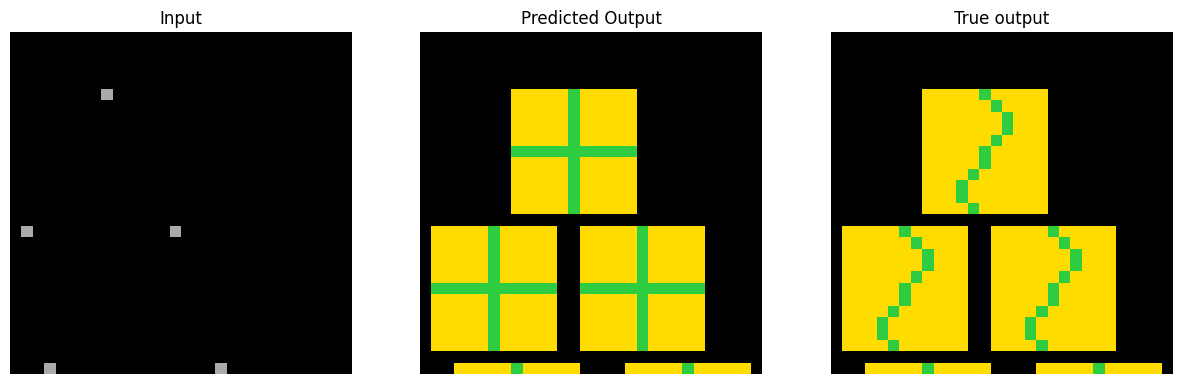

In [22]:
best_context = contexts[log_probs_list[-1].argmax()]

output_grids, output_shapes = lpn.apply(
    {"params": loaded_state.params}, best_context[None], input, input_grid_shape, dropout_eval, method=lpn._generate_output_from_context
)

_, axs = plt.subplots(1, 3, figsize=(15, 10))

axs[0].set_title("Input")
display_grid(axs[0], input[0], input_grid_shape[0])
axs[1].set_title("Predicted Output")
display_grid(axs[1], output_grids[0], output_shapes[0])
axs[2].set_title("True output")
display_grid(axs[2], output[0], output_grid_shape[0])
plt.show()

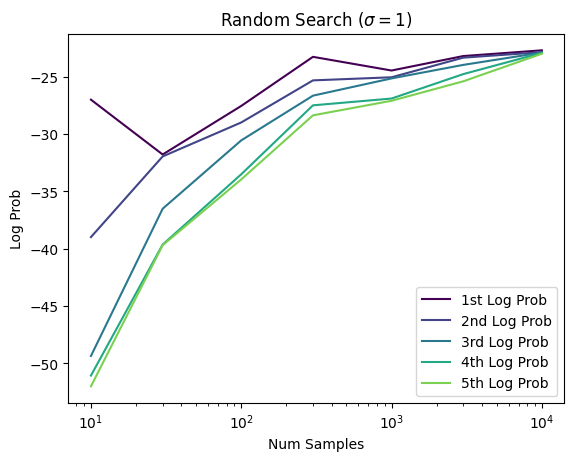

In [36]:
cmap = plt.get_cmap("viridis")
plt.plot(num_samples_per_scales, [log_probs.max() for log_probs in log_probs_list], label="1st Log Prob", color=cmap(0.0))
plt.plot(num_samples_per_scales, [jax.numpy.sort(log_probs, descending=True)[1] for log_probs in log_probs_list], label="2nd Log Prob", color=cmap(0.2))
plt.plot(num_samples_per_scales, [jax.numpy.sort(log_probs, descending=True)[2] for log_probs in log_probs_list], label="3rd Log Prob", color=cmap(0.4))
plt.plot(num_samples_per_scales, [jax.numpy.sort(log_probs, descending=True)[3] for log_probs in log_probs_list], label="4th Log Prob", color=cmap(0.6))
plt.plot(num_samples_per_scales, [jax.numpy.sort(log_probs, descending=True)[4] for log_probs in log_probs_list], label="5th Log Prob", color=cmap(0.8))
plt.xlabel("Num Samples")
plt.ylabel("Log Prob")
plt.title(r"Random Search $(\sigma=1)$")
plt.legend()
plt.xscale("log")
plt.show()

## Gradient Ascent

In [69]:
lr = 5e-2

input_seq, output_seq = lpn._flatten_input_output_for_decoding(pairs.squeeze(0), grid_shapes.squeeze(0))
search_latents = latents.squeeze(0).mean(axis=-2)

def log_probs_fn(latents, input_seq, output_seq):
    # Use the same latent for all pairs of the same task.
    latents = latents[..., None, :].repeat(output_seq.shape[-2], axis=-2)
    row_logits, col_logits, grid_logits = lpn.decoder.apply(
        {"params": loaded_state.params["decoder"]}, input_seq, output_seq, latents, dropout_eval=True,
    )
    log_probs = lpn.apply({"params": loaded_state.params}, row_logits, col_logits, grid_logits, output_seq, method=lpn._compute_log_probs)
    return log_probs

def update_latents(latents):
    log_probs, grads = jax.value_and_grad(log_probs_fn)(latents, input_seq, output_seq)
    assert grads.shape == latents.shape
    new_latents = latents + lr * jax.lax.stop_gradient(grads)
    return new_latents, log_probs

for i in range(20):
    old_latents = search_latents
    search_latents, log_probs = update_latents(search_latents)
    distances = jax.numpy.linalg.norm(old_latents - latents.squeeze(0).mean(axis=-2), axis=-1)
    print(f"Step {i} >> log_prob: {log_probs.mean():.1f}, dist to mean: {distances:.3f}")
distances = jax.numpy.linalg.norm(search_latents - latents.squeeze(0).mean(axis=-2), axis=-1)
log_probs = log_probs_fn(search_latents, input_seq, output_seq)
print(f"Step {i+1} >> log_prob: {log_probs:.1f}, dist to mean: {distances:.3f}")

Step 0 >> log_prob: -49.3, dist to mean: 0.000
Step 1 >> log_prob: -28.3, dist to mean: 1.273
Step 2 >> log_prob: -25.0, dist to mean: 1.712
Step 3 >> log_prob: -23.5, dist to mean: 1.985
Step 4 >> log_prob: -22.6, dist to mean: 2.174
Step 5 >> log_prob: -22.1, dist to mean: 2.312
Step 6 >> log_prob: -21.6, dist to mean: 2.420
Step 7 >> log_prob: -21.3, dist to mean: 2.509
Step 8 >> log_prob: -21.0, dist to mean: 2.585
Step 9 >> log_prob: -20.8, dist to mean: 2.654
Step 10 >> log_prob: -20.5, dist to mean: 2.717
Step 11 >> log_prob: -20.3, dist to mean: 2.776
Step 12 >> log_prob: -20.2, dist to mean: 2.833
Step 13 >> log_prob: -20.0, dist to mean: 2.887
Step 14 >> log_prob: -19.9, dist to mean: 2.939
Step 15 >> log_prob: -19.7, dist to mean: 2.989
Step 16 >> log_prob: -19.6, dist to mean: 3.038
Step 17 >> log_prob: -19.5, dist to mean: 3.085
Step 18 >> log_prob: -19.4, dist to mean: 3.131
Step 19 >> log_prob: -19.3, dist to mean: 3.176
Step 20 >> log_prob: -19.2, dist to mean: 3.220


/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:9

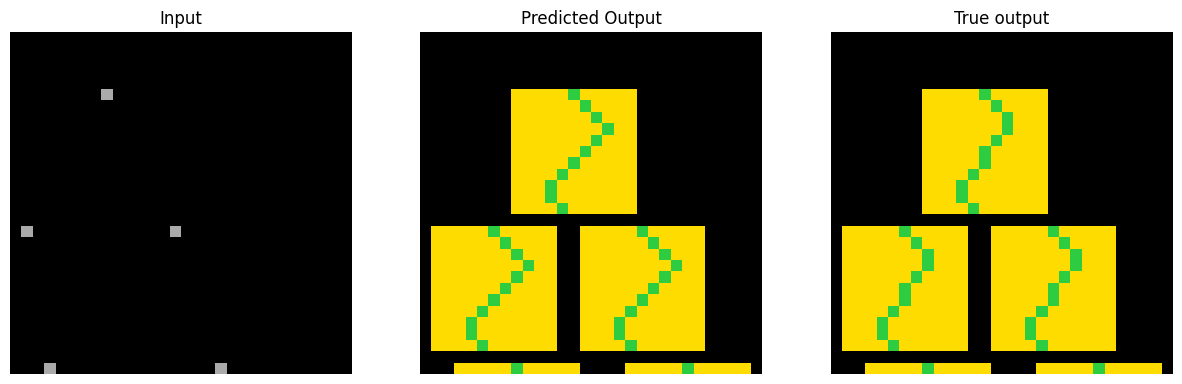

In [70]:
best_context = search_latents
output_grids, output_shapes = lpn.apply(
    {"params": loaded_state.params}, best_context[None], input, input_grid_shape, dropout_eval, method=lpn._generate_output_from_context
)

_, axs = plt.subplots(1, 3, figsize=(15, 10))

axs[0].set_title("Input")
display_grid(axs[0], input[0], input_grid_shape[0])
axs[1].set_title("Predicted Output")
display_grid(axs[1], output_grids[0], output_shapes[0])
axs[2].set_title("True output")
display_grid(axs[2], output[0], output_grid_shape[0])
plt.show()

### Generate one of the output from the given pairs

/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/clement/arc/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:9

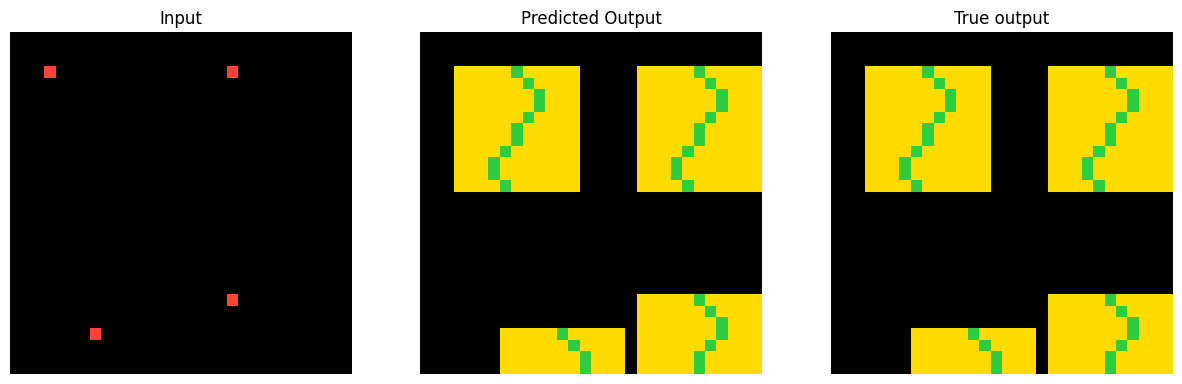

In [71]:
best_context = search_latents
pairs_input = grid[None, 1, :, :, 0]
pairs_input_grid_shape = shape[None, 1, :, 0]

pairs_output = grid[None, 1, :, :, 1]
pairs_output_grid_shape = shape[None, 1, :, 1]

output_grids, output_shapes = lpn.apply(
    {"params": loaded_state.params}, best_context[None], pairs_input, pairs_input_grid_shape, dropout_eval, method=lpn._generate_output_from_context
)

_, axs = plt.subplots(1, 3, figsize=(15, 10))

axs[0].set_title("Input")
display_grid(axs[0], pairs_input[0], pairs_input_grid_shape[0])
axs[1].set_title("Predicted Output")
display_grid(axs[1], output_grids[0], output_shapes[0])
axs[2].set_title("True output")
display_grid(axs[2], pairs_output[0], pairs_output_grid_shape[0])
plt.show()

# Analyse ARC TRAIN GENERATOR

In [6]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

from src.datasets.task_gen.task_generator import ArcTrainTaskGenerator
from src.datasets.task_gen.utils import plot_task
from src.visualization import arc_cmap, arc_norm

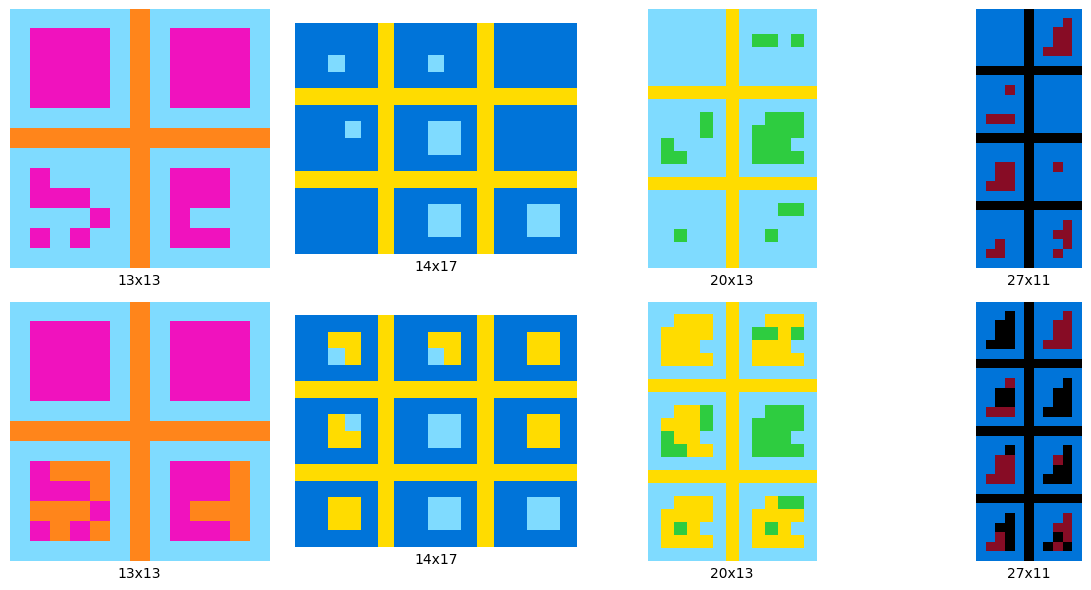

In [7]:
task_gen = ArcTrainTaskGenerator(num_pairs=4, seed=0)
task, _ = next(iter(task_gen))
plot_task(task)

In [8]:
encoder_call = jax.jit(
    lambda pairs, grid_shapes: lpn.encoder.apply(
        {"params": loaded_state.params["encoder"]},
        pairs=pairs,
        grid_shapes=grid_shapes,
        dropout_eval=True,
        method=lpn.encoder.__call__,
    )
)
generate_output_from_context = jax.jit(
    lambda context, input, input_grid_shape: lpn.apply(
        {"params": loaded_state.params},
        context=context,
        input=input,
        input_grid_shape=input_grid_shape,
        dropout_eval=True,
        method=lpn._generate_output_from_context,
    )
)

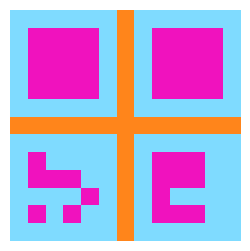

In [9]:
inputs = jnp.stack([jnp.pad(pair["input"], ((0, 30 - pair["input"].shape[0]), (0, 30 - pair["input"].shape[1]))) for pair in task])
outputs = jnp.stack([jnp.pad(pair["output"], ((0, 30 - pair["output"].shape[0]), (0, 30 - pair["output"].shape[1]))) for pair in task])
pairs = jnp.stack([inputs, outputs], axis=-1)
grid_shapes = jnp.array([[[pair["input"].shape[0], pair["output"].shape[0]], [pair["input"].shape[1], pair["output"].shape[1]]] for pair in task])
latents_mu, latents_logvar = encoder_call(pairs=pairs, grid_shapes=grid_shapes)
latents = latents_mu
context = latents[1:].mean(axis=0)
output_grids, output_shapes = generate_output_from_context(
    context=context[None], input=inputs[0][None], input_grid_shape=grid_shapes[0, :, 0][None]
)
plt.figure(figsize=(3, 3))
plt.imshow(output_grids[0, :output_shapes[0, 0], :output_shapes[0, 1]], cmap=arc_cmap, norm=arc_norm, origin="lower")
plt.axis("off")
plt.show()

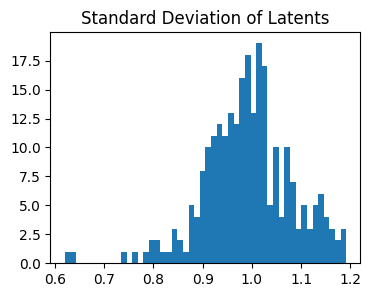

In [10]:
latents_std = jnp.exp(0.5 * latents_logvar)
plt.figure(figsize=(4, 3))
plt.hist(latents_std[0], bins=50)
plt.title("Standard Deviation of Latents")
plt.show()

In [11]:
@jax.jit
def log_prob_other_pairs(context):
    input_seq, output_seq = lpn._flatten_input_output_for_decoding(pairs[1:], grid_shapes[1:])
    row_logits, col_logits, grid_logits = lpn.decoder.apply(
        {"params": loaded_state.params["decoder"]},
        input_seq=input_seq,
        output_seq=output_seq,
        context=context[..., None, :].repeat(output_seq.shape[-2], axis=-2),
        dropout_eval=True,
    )
    log_probs = lpn._compute_log_probs(row_logits, col_logits, grid_logits, output_seq)
    return log_probs

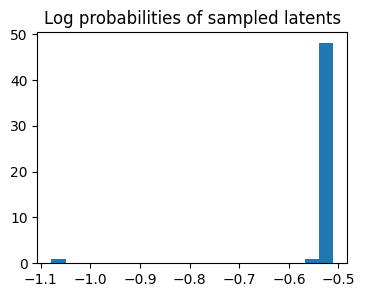

In [13]:
keys = jax.random.split(jax.random.PRNGKey(0), 50)
latents, *_ = jax.vmap(lpn._sample_latents, (None, None, 0))(latents_mu[0], latents_logvar[0], keys)
log_probs = [log_prob_other_pairs(latent) for latent in latents]
plt.figure(figsize=(4, 3))
plt.hist(log_probs, bins=20)
plt.title("Log probabilities of sampled latents")
plt.show()

In [14]:
grad_fn = jax.jit(jax.value_and_grad(log_prob_other_pairs))

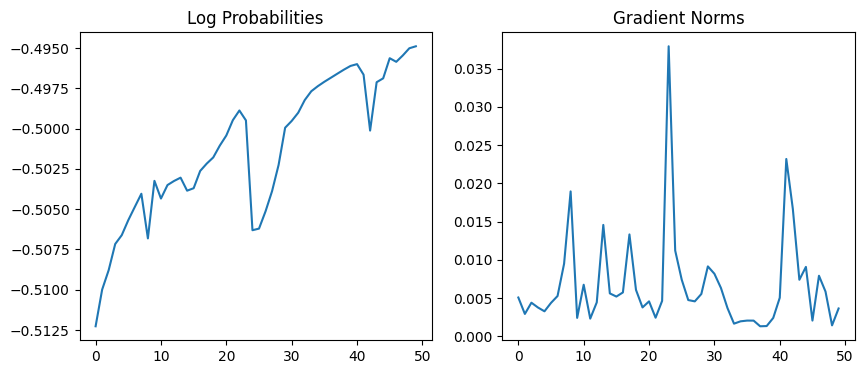

In [16]:
# Gradient ascent
lr = 0.05
optimizer = optax.adam(learning_rate=lr, b1=0.5)
start_context = context
current_context = start_context
opt_state = optimizer.init(current_context)
contexts, log_probs, grad_norms = [current_context], [], []
for _ in range(50):
    log_prob, grad = grad_fn(current_context)
    updates, opt_state = optimizer.update(-grad, opt_state)
    current_context += updates
    contexts.append(current_context)
    log_probs.append(log_prob)
    grad_norms.append(jnp.linalg.norm(grad))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_probs)
plt.title("Log Probabilities")
plt.subplot(1, 2, 2)
plt.plot(grad_norms)
plt.title("Gradient Norms")
plt.show()

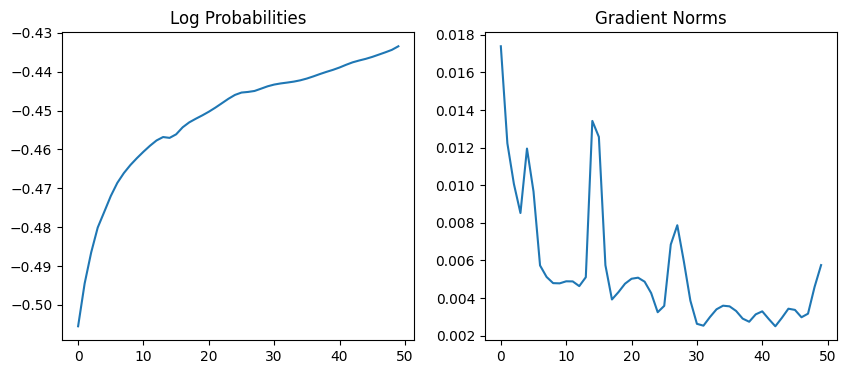

In [62]:
# Gradient ascent
lr = 0.1
optimizer = optax.adam(learning_rate=lr)
start_context = context
current_context = start_context
opt_state = optimizer.init(current_context)
contexts, log_probs, grad_norms = [current_context], [], []
for _ in range(50):
    log_prob, grad = grad_fn(current_context)
    updates, opt_state = optimizer.update(-grad, opt_state)
    current_context += updates
    contexts.append(current_context)
    log_probs.append(log_prob)
    grad_norms.append(jnp.linalg.norm(grad))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_probs)
plt.title("Log Probabilities")
plt.subplot(1, 2, 2)
plt.plot(grad_norms)
plt.title("Gradient Norms")
plt.show()

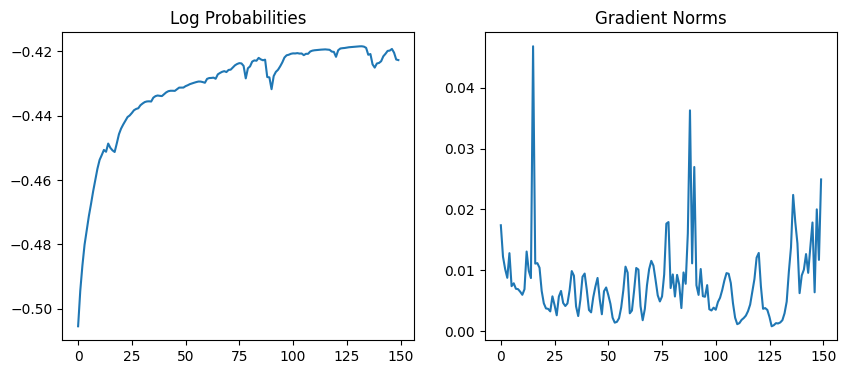

In [63]:
# Gradient ascent
lr = 0.1
optimizer = optax.adam(learning_rate=lr, b1=0.5)
start_context = context
current_context = start_context
opt_state = optimizer.init(current_context)
contexts, log_probs, grad_norms = [current_context], [], []
for _ in range(150):
    log_prob, grad = grad_fn(current_context)
    updates, opt_state = optimizer.update(-grad, opt_state)
    current_context += updates
    contexts.append(current_context)
    log_probs.append(log_prob)
    grad_norms.append(jnp.linalg.norm(grad))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_probs)
plt.title("Log Probabilities")
plt.subplot(1, 2, 2)
plt.plot(grad_norms)
plt.title("Gradient Norms")
plt.show()

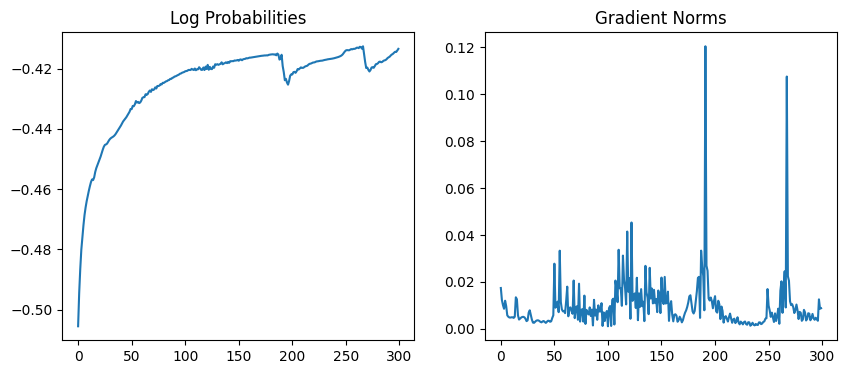

In [64]:
# Gradient ascent
lr = 0.1
optimizer = optax.adam(learning_rate=lr)
start_context = context
current_context = start_context
opt_state = optimizer.init(current_context)
contexts, log_probs, grad_norms = [current_context], [], []
for _ in range(300):
    log_prob, grad = grad_fn(current_context)
    updates, opt_state = optimizer.update(-grad, opt_state)
    current_context += updates
    contexts.append(current_context)
    log_probs.append(log_prob)
    grad_norms.append(jnp.linalg.norm(grad))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_probs)
plt.title("Log Probabilities")
plt.subplot(1, 2, 2)
plt.plot(grad_norms)
plt.title("Gradient Norms")
plt.show()

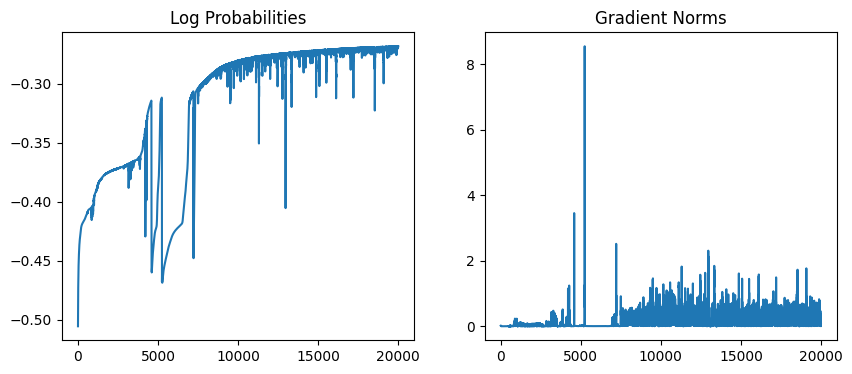

In [91]:
# Gradient ascent
lr = 0.03
optimizer = optax.adam(learning_rate=lr)
start_context = context
current_context = start_context
opt_state = optimizer.init(current_context)
contexts, log_probs, grad_norms = [current_context], [], []
for _ in range(20000):
    log_prob, grad = grad_fn(current_context)
    updates, opt_state = optimizer.update(-grad, opt_state)
    current_context += updates
    contexts.append(current_context)
    log_probs.append(log_prob)
    grad_norms.append(jnp.linalg.norm(grad))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_probs)
plt.title("Log Probabilities")
plt.subplot(1, 2, 2)
plt.plot(grad_norms)
plt.title("Gradient Norms")
plt.show()

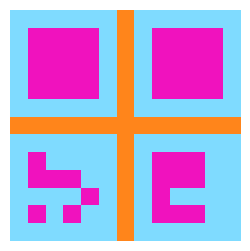

In [93]:
output_grids, output_shapes = generate_output_from_context(
    context=contexts[-1][None], input=inputs[0][None], input_grid_shape=grid_shapes[0, :, 0][None]
)
plt.figure(figsize=(3, 3))
plt.imshow(output_grids[0, :output_shapes[0, 0], :output_shapes[0, 1]], cmap=arc_cmap, norm=arc_norm, origin="lower")
plt.axis("off")
plt.show()

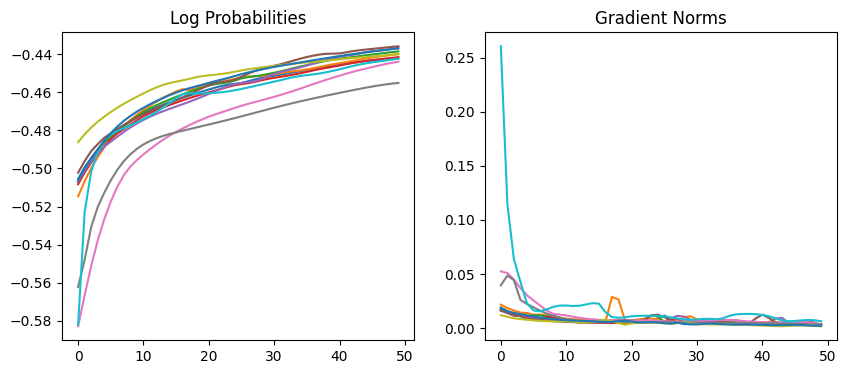

In [87]:
latents_mu, latents_logvar = encoder_call(pairs=pairs, grid_shapes=grid_shapes)
latents = latents_mu

mean_latent = latents[1:].mean(axis=-2, keepdims=True)
all_latents = mean_latent

num_samples = 5
scale = 0.2
random_vectors = jax.random.normal(jax.random.PRNGKey(0), (num_samples, latents.shape[-1]))
random_latents = mean_latent + scale * random_vectors
all_latents = jnp.concatenate([all_latents, random_latents], axis=-2)

num_samples = 5
scale = 1.0
random_vectors = jax.random.normal(jax.random.PRNGKey(1), (num_samples, latents.shape[-1]))
random_latents = mean_latent + scale * random_vectors
all_latents = jnp.concatenate([all_latents, random_latents], axis=-2)


# Gradient ascent from different starts
grad_fn = jax.jit(jax.vmap(jax.value_and_grad(log_prob_other_pairs)))
lr = 0.05
optimizer = optax.adam(learning_rate=lr)
current_contexts = all_latents
opt_state = optimizer.init(current_contexts)
contexts_list, log_probs_list, grad_norms_list = [current_contexts], [], []
for _ in range(50):
    log_probs, grads = grad_fn(current_contexts)
    updates, opt_state = optimizer.update(-grads, opt_state)
    current_contexts += updates
    contexts_list.append(current_contexts)
    log_probs_list.append(log_probs)
    grad_norms_list.append(jnp.linalg.norm(grads, axis=-1))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for i in range(len(log_probs_list[0])):
    plt.plot([log_probs[i] for log_probs in log_probs_list])
plt.title("Log Probabilities")
plt.subplot(1, 2, 2)
for i in range(len(grad_norms_list[0])):
    plt.plot([grad_norms[i] for grad_norms in grad_norms_list])
plt.title("Gradient Norms")
plt.show()